In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pandas as pd
from mpl_toolkits import mplot3d
from scipy.stats import spearmanr
import collections
import feather
from scipy import stats
import seaborn as sns
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


import sys
sys.path.append('../')
import utils
import plotting


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### formatting
column 1 is yyyy_dd_hh
row 1 is generator # (s/a in the generator input file)

#### to do
1. sum each row to get the annual total per generator
2. sum the rows by state in which the generator is located
3. import egrids data
4. subtract the model output by state from the state annual emissions from egrid

#### approach
1. see if the data is linearly correlated or what the relationship is between the model/generation
2. see if a specific type of power plant is off and others are correct
3. see if a specific region of power plant is off

# Import Data

In [8]:
models = ['normal','nonuc']
pollutants = ['NO','NO2','SO2','CO2','CH4']

regionname_grouped_ds = xr.open_dataset(f'./data/regionname_grouped_emissions_ds.nc')
fueltype_grouped_ds = xr.open_dataset(f'./data/fueltype_grouped_emissions_ds.nc')
gmodel_egrid_ds = xr.open_dataset(f'./data/gmodel_egrid_emissions_ds.nc')
oris_nonuc_ds = xr.open_dataset(f'../optimization_model/outputs/oris_nonuc_ds.nc')

# Plot settings

In [9]:
###set color for each type
nonuc_color = 'C1'
normal_color = 'C0'
egrid_color = 'C7'

### set scientific names
sci_names = {'NO':r'$NO$', 'SO2':r'$SO_2$', 'NO2':r'$NO_2$', 'CO2':r'$CO_2$', 'CH4':r'$CH_4$' }

# Generator use in the no-nuclear scenario

### NEED TO GET REGION NAMES

In [32]:
###determine which regions are using a generator and when
#get list of unique region names and what generators are in which location
reg = np.unique(oris_nonuc_ds['RegionName'])
generator_oris_number = np.arange(100000,100000+len(reg))
#make a dict of region names and their associated oris number
generator_oris_dict = {generator_oris_number[idx]:f'{r}' for idx,r in enumerate(reg)} 

#make a column for generator generation in dataset
gmodel_egrid_ds['generator_generation'] = gmodel_egrid_ds['modelgeneration'].copy()
gmodel_egrid_ds['generator_generation'] = gmodel_egrid_ds['generator_generation'].where(gmodel_egrid_ds['fueltype'] == 'generator')
gmodel_egrid_ds['generator_generation'] = gmodel_egrid_ds['generator_generation'].where(gmodel_egrid_ds['generator_generation'] != 0)

#make a column for our sum of generator generation to find which ORISCodes have generators turned on
gmodel_egrid_ds['generator_generation_sum'] = gmodel_egrid_ds['generator_generation'].sum(dim='date')
ORIS_using_gen = gmodel_egrid_ds.sel(model_name = 'nonuc')['generator_generation_sum'].isel(
    ORISCode = (gmodel_egrid_ds.sel(model_name = 'nonuc')['generator_generation_sum'] > 0))['ORISCode'].values

#find the region in which the generator is located
reg_using_gen = generator_oris_dict[ORIS_using_gen.item()]
print('Regions using generators are ' + str(reg_using_gen))


KeyError: 100002

In [20]:


for key, value in generator_oris_dict.items(): 
    if reg_using_gen == value: 
        ORIS_gen_code = key
        print('Region generator Oris Code is ' + str(ORIS_gen_code))

#find the times this region is using the generator
times_using_gen = gmodel_egrid_ds.sel(model_name = 'nonuc')['generator_generation'].sel(ORISCode = ORIS_gen_code).isel(date = (gmodel_egrid_ds.sel(model_name = 'nonuc')['generator_generation'].sel(ORISCode = ORIS_using_gen.values.item()) > 0))['date'].values
daily_gen_use = gmodel_egrid_ds.sel(model_name = 'nonuc')['generator_generation'].sel(ORISCode = ORIS_gen_code).isel(date = (gmodel_egrid_ds.sel(model_name = 'nonuc')['generator_generation'].sel(ORISCode = ORIS_using_gen.values.item()) > 0)).values
print('\nTimes generator is used and amounts used are \n' + str(times_using_gen) + '\n' + str(daily_gen_use))

#print the total generation used
print('\nAnnual total generation produced by generators \n' + str(gmodel_egrid_ds.sel(model_name = 'nonuc')['generator_generation_sum'].sum().values))

#make a dataframe with our generator information
generator_df = pd.DataFrame(data = daily_gen_use, index = times_using_gen, columns = ['Generation'])
generator_df = generator_df.rename_axis('Time')

KeyError: 100002

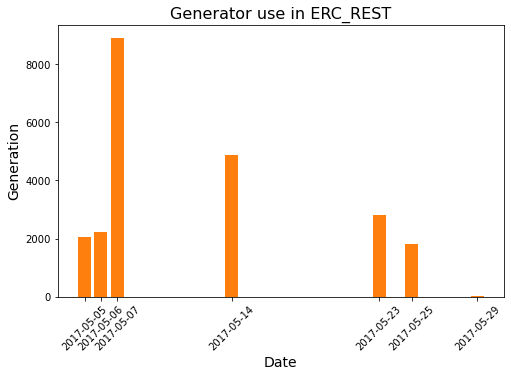

In [18]:
#### plot the generator use in this region ####
fig,ax = plt.subplots(figsize = [8,5])
plt.bar(generator_df.groupby(generator_df.index.date).sum().index, generator_df.groupby(generator_df.index.date).sum()['Generation'], color = nonuc_color)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Generation', fontsize = 14)
plt.xticks(generator_df.groupby(generator_df.index.date).sum().index, rotation = 45)
plt.title(f'Generator use in {reg_using_gen}', fontsize = 16);

## Correlation between Normal Dataset and Egrid

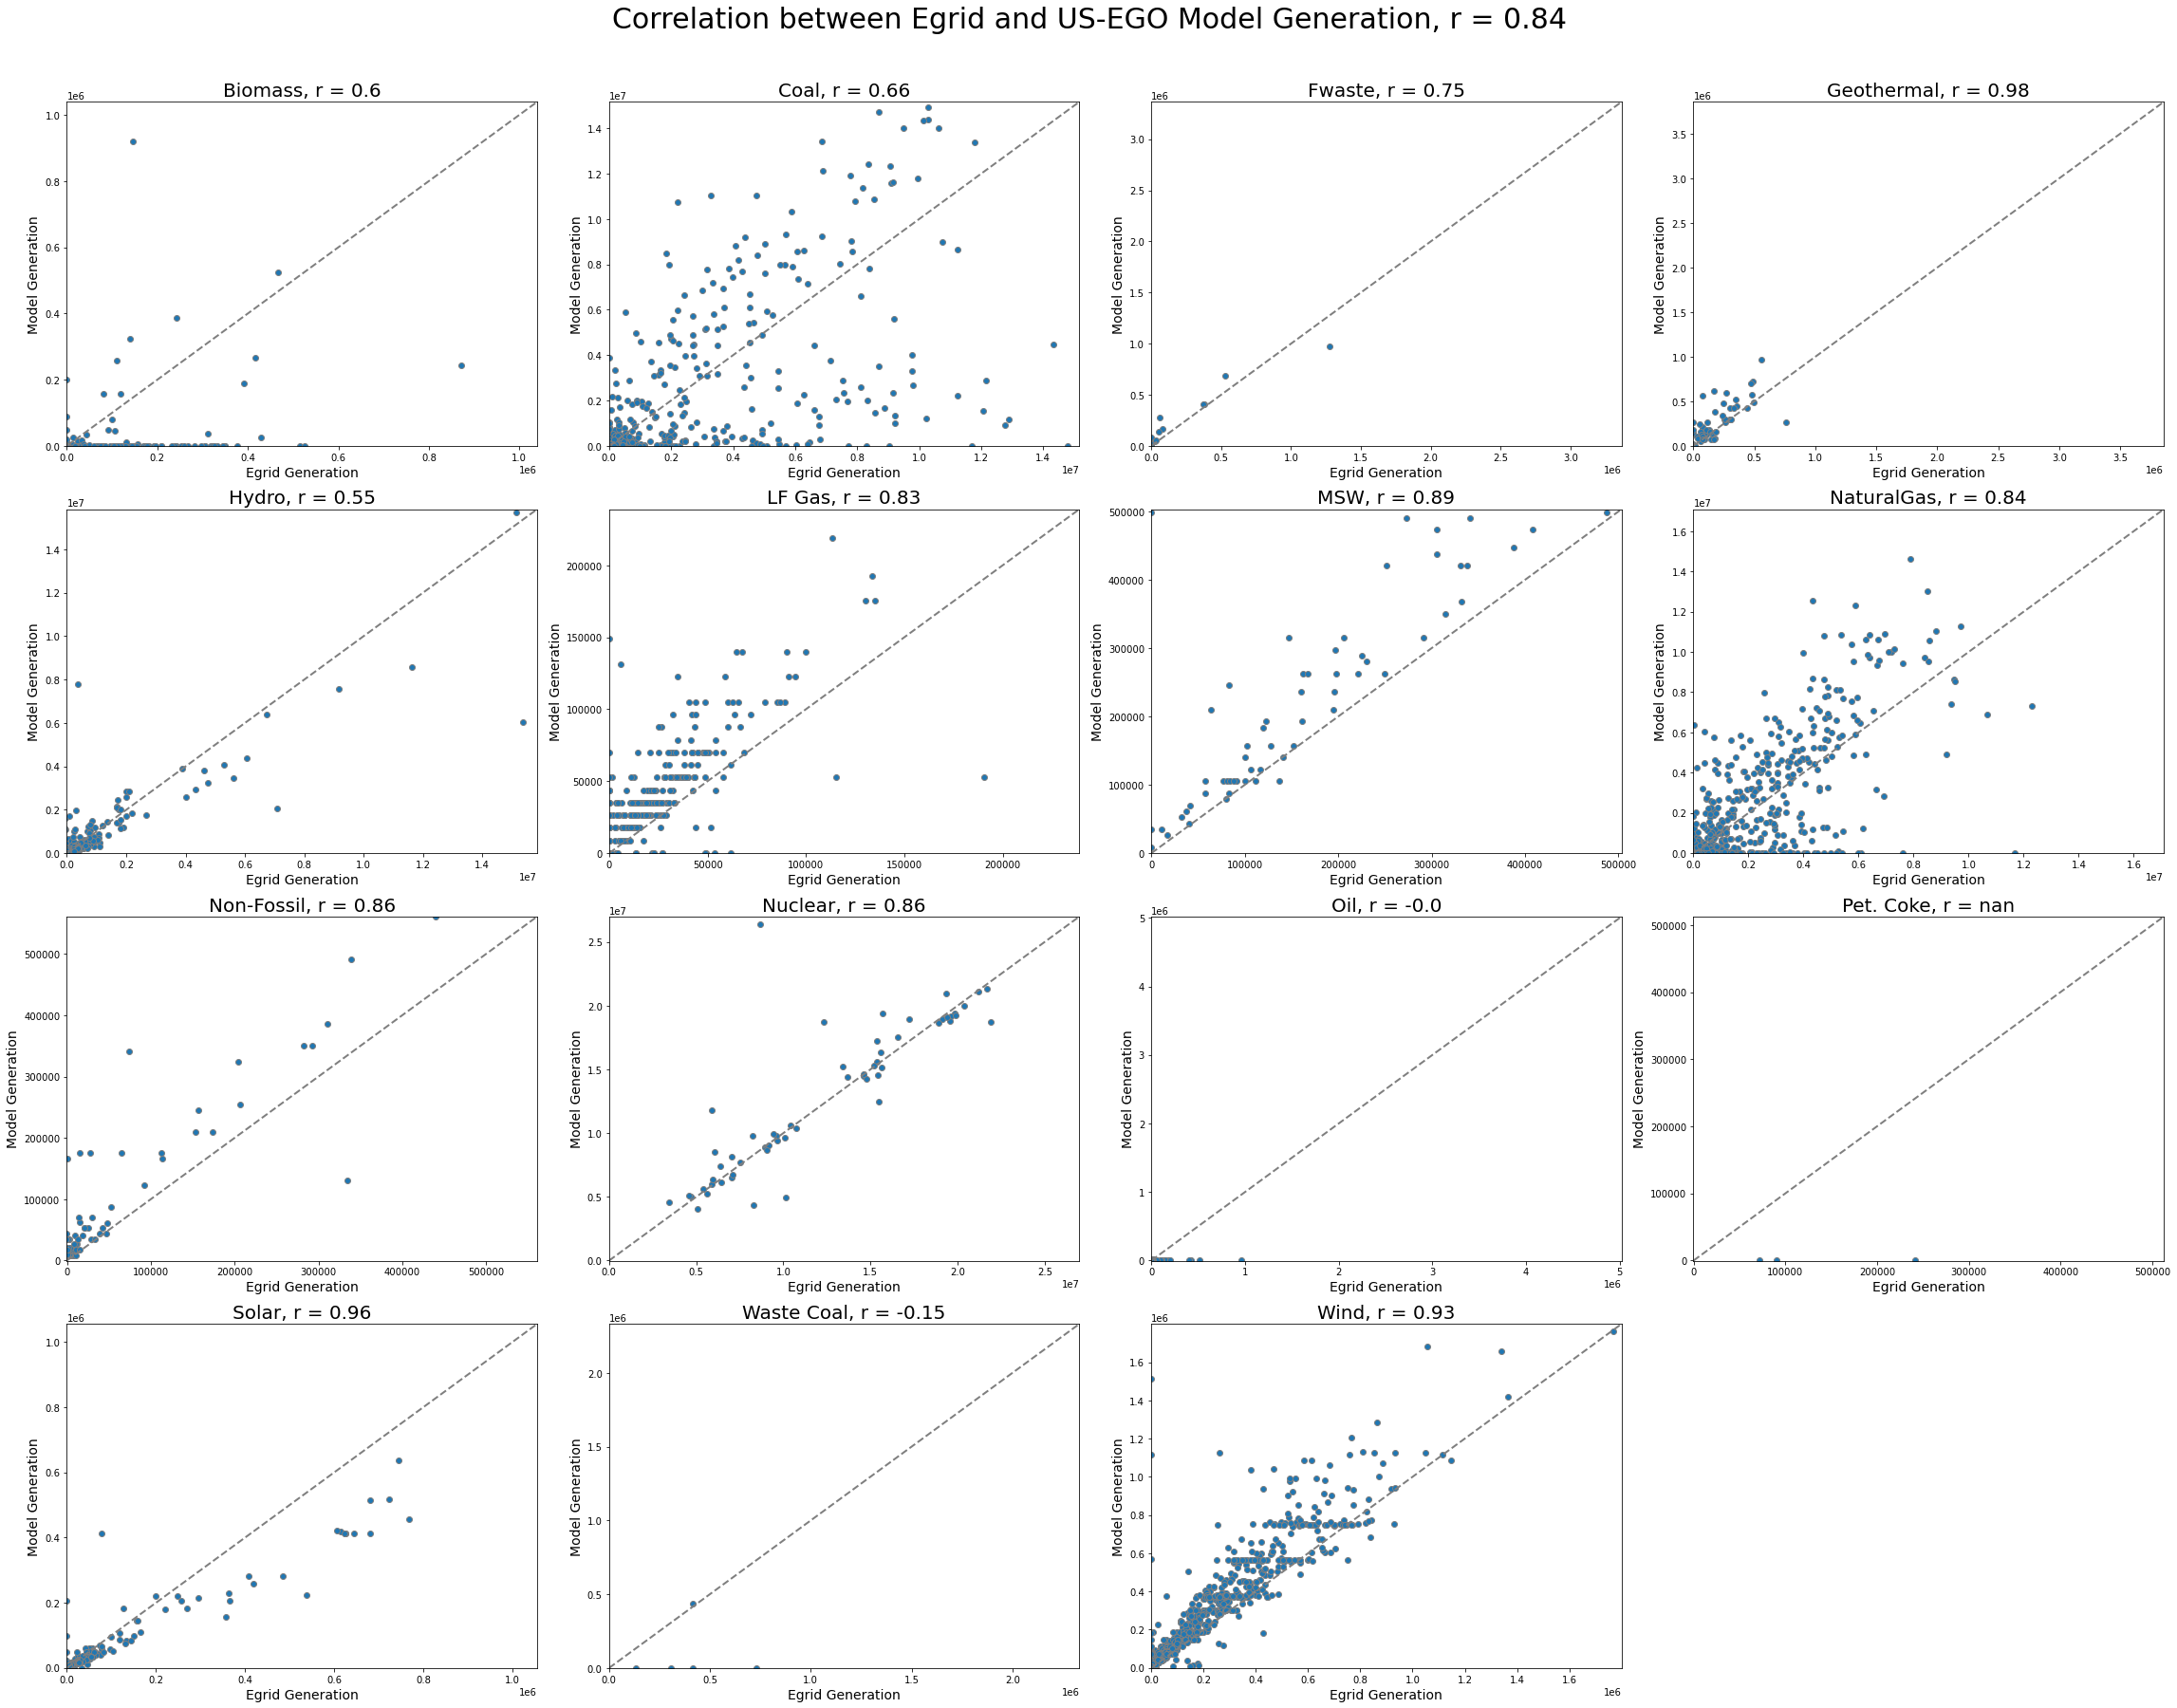

In [71]:
#find the correlation of coal production between 
source_list = ['Biomass', 'Coal', 'Fwaste', 'Geothermal', 'Hydro', 'LF Gas',
       'MSW', 'NaturalGas', 'Non-Fossil', 'Nuclear', 'Oil', 'Pet. Coke',
       'Solar', 'Waste Coal', 'Wind']
fig = plt.figure(figsize = [32,24])
for idx,src in enumerate(source_list):
    #make subplots
    ax = fig.add_subplot(4,4,idx+1)
    #plot a scatterplot
    ax = gmodel_egrid_ds.sel(model_name = 'normal').sel(ORISCode = (gmodel_egrid_ds.sel(model_name = 'normal')['fueltype'] == src)).plot.scatter(
        x='egridgeneration', 
        y='annual_modelgeneration', 
        c=normal_color, 
        marker='o', 
        edgecolors = 'C7')
    #create a max for the x and y lims
    MM = max(gmodel_egrid_ds.sel(model_name = 'normal').sel(
        ORISCode = (gmodel_egrid_ds.sel(model_name = 'normal')['fueltype'] == src))['egridgeneration'].max(), 
             gmodel_egrid_ds.sel(model_name = 'normal').sel(
        ORISCode = (gmodel_egrid_ds.sel(model_name = 'normal')['fueltype'] == src))['modelgeneration'].max())/1.2
    #plot 1:1 line
    plt.plot(np.arange(0, MM, 100), np.arange(0,MM, 100), '--C7', linewidth = 2)
    #calculate the correlation
    corr = np.round(gmodel_egrid_ds.sel(model_name = 'normal').sel(
        ORISCode = (gmodel_egrid_ds.sel(model_name = 'normal')['fueltype'] == src))['annual_modelgeneration'].to_pandas().corr(gmodel_egrid_ds.sel(model_name = 'normal').sel(
        ORISCode = (gmodel_egrid_ds.sel(model_name = 'normal')['fueltype'] == src))['egridgeneration'].to_pandas()), 2)
    #modify labels and limits
    plt.xlabel('Egrid Generation', fontsize = 14)
    plt.ylabel('Model Generation', fontsize = 14)
    plt.xlim([-100, MM]);
    plt.ylim([-100, MM]);
    plt.title(f'{src}, r = {corr}', fontsize = 20)
    
    
plt.tight_layout()
plt.suptitle('Correlation between Egrid and US-EGO Model Generation, r = ' 
             + str(np.round(gmodel_egrid_ds.sel(model_name = 'normal')['annual_modelgeneration'].to_pandas().corr(gmodel_egrid_ds.sel(model_name = 'normal')['egridgeneration'].to_pandas()), 2)), 
             fontsize = 30, y = 1.04);

## Generation by plant type and region name

No handles with labels found to put in legend.


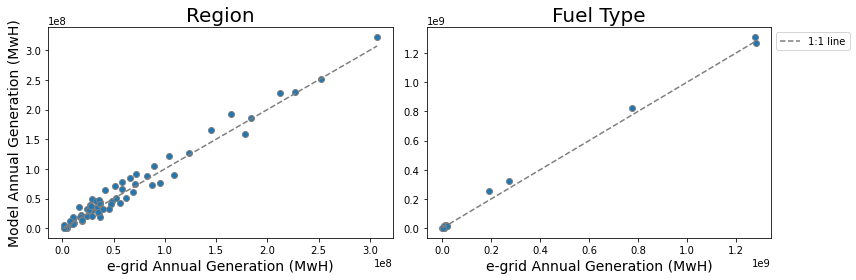

In [103]:
### plot scatter of region annual emissions vs egrid
fig, axes = plt.subplots(1,2, figsize = [12,4])
for idx, ds in enumerate([regionname_grouped_ds, fueltype_grouped_ds]):
    ax = axes[idx]
    x = ds.sel(model_name = 'normal')['egridgeneration'].values
    y = ds.sel(model_name = 'normal')['annual_modelgeneration'].values
    ax.scatter(x, y, edgecolors = 'C7')
    ax.set_xlabel('e-grid Annual Generation (MwH)', fontsize = 14)
    ax.set_title(ds.sel(model_name = 'normal').attrs['group'], fontsize = 20)
    #plot 1:1 line
    xlin = np.linspace(x.min(),x.max(),100)
    ylin = xlin
    ax.plot(xlin, ylin, '--C7', label='1:1 line');
    plt.legend(bbox_to_anchor = [1.0, 1.0])
axes[0].set_ylabel('Model Annual Generation (MwH)', fontsize = 14)
plt.tight_layout()
#plt.savefig('./Figures/egrid_model.png', bbox_inches = 'tight', dpi = 150)

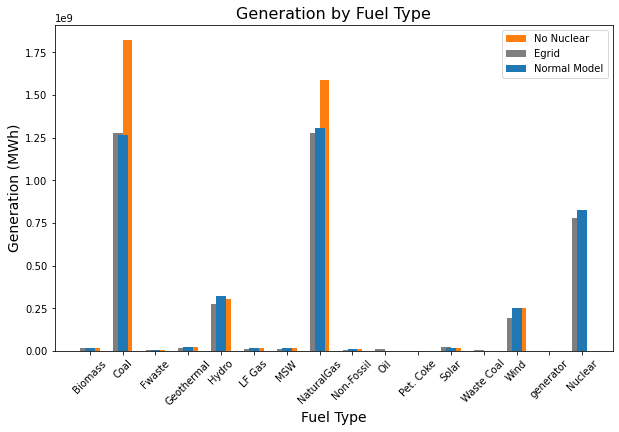

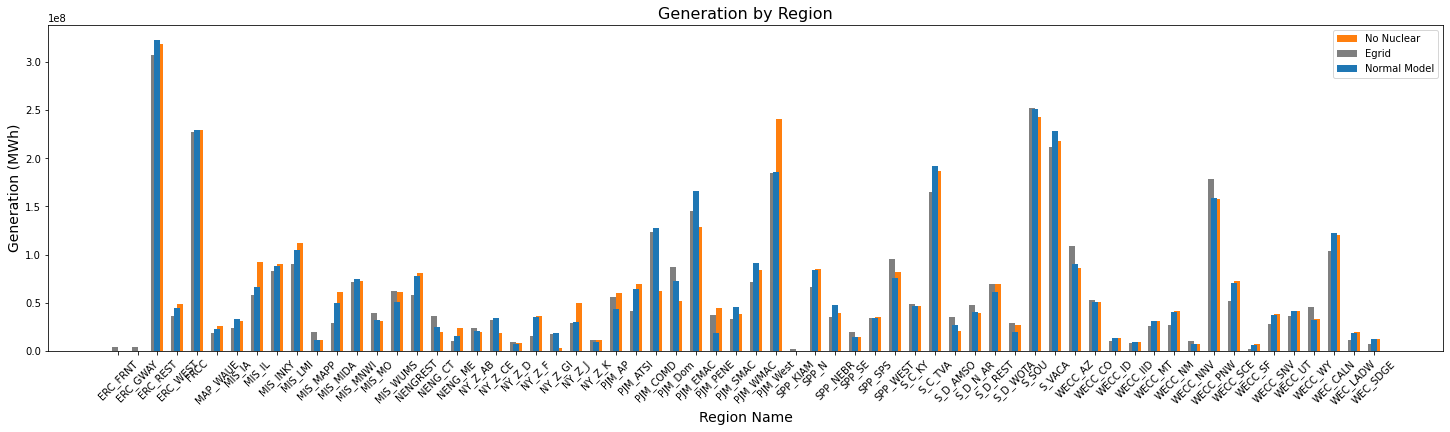

In [106]:
### plot all three egrid, nonuc, normal model generation by:

#fuel type
plotting.plant_region_plot(fueltype_grouped_ds, xvariable = 'fueltype', yvariable1 = 'annual_modelgeneration',egrid = True, yvariable2 = 'egridgeneration', figsize = [10,6])
plt.xlabel('Fuel Type', fontsize = 14)
plt.ylabel('Generation (MWh)', fontsize = 14)
plt.title('Generation by Fuel Type', fontsize = 16);
#plt.savefig('./Figures/fuel_type_all.png', dpi=300, bbox_inches = 'tight')

#region name
plotting.plant_region_plot(regionname_grouped_ds, xvariable = 'regionname',egrid = True, yvariable1 = 'annual_modelgeneration', yvariable2 = 'egridgeneration', figsize = [25,6])
plt.xlabel('Region Name', fontsize = 14)
plt.ylabel('Generation (MWh)', fontsize = 14)
plt.title('Generation by Region', fontsize = 16);
#plt.savefig('./Figures/region_name_all.png', dpi=300, bbox_inches = 'tight')


## Total Changes

No handles with labels found to put in legend.


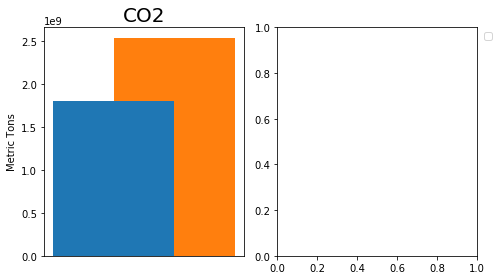

In [44]:
fig,axes = plt.subplots(1, 2, figsize=[7,4])
for idx_p, pollutant in enumerate(['CO2']):
    ax = axes[idx_p]
    ax.bar(pollutant, gmodel_egrid_ds.sel(model_name = 'nonuc')[pollutant].sum().values*.001*3600, color = nonuc_color, width = .3, align = 'edge', label = 'No Nuclear')
    ax.bar(pollutant, gmodel_egrid_ds.sel(model_name = 'normal')[pollutant].sum().values*.001*3600, color = normal_color, width = .3, label = 'Normal')
    ax.set_title(pollutant, fontsize = 20)
    ax.tick_params(axis = "x", which = "both", bottom = False, labelbottom = False)
axes[0].set_ylabel('Metric Tons')
plt.legend(bbox_to_anchor = [1.1, 1.0])
plt.tight_layout();
plt.savefig('CO2_dif.png', )

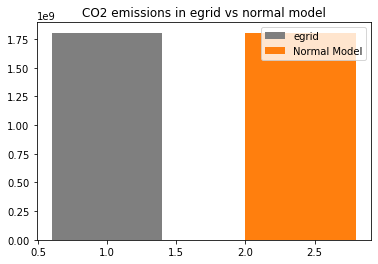

In [45]:
#### egrid vs model emissions ####
pollutant = 'CO2'
fig = plt.subplots()
q = plt.bar(1, (gmodel_egrid_ds.sel(model_name = 'normal')['egridgeneration']*gmodel_egrid_ds.sel(model_name = 'normal')[f'PL{pollutant}RTA']).sum().values*.001, color = egrid_color, label = 'egrid')
q = plt.bar(2, (gmodel_egrid_ds.sel(model_name = 'normal')['annual_modelgeneration']*gmodel_egrid_ds.sel(model_name = 'normal')[f'PL{pollutant}RTA']).sum().values*.001, color = nonuc_color, align = 'edge', label = 'Normal Model')
plt.legend()
plt.title(f'{pollutant} emissions in egrid vs normal model');

## Emissions by region and fuel type

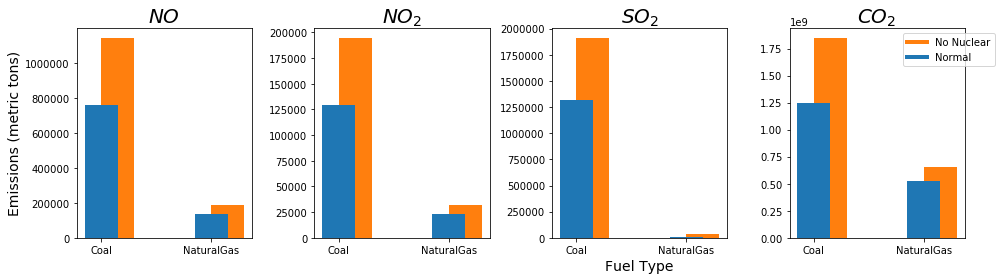

In [46]:
#plot by fuel type
plotting.fossil_fuel_plot(fueltype_grouped_ds, sci_names = sci_names, xvariable = 'fueltype', 
                          pollutants = ['NO','NO2','SO2','CO2'], figsize = [14,4],
                         nonuc_color = nonuc_color, normal_color = normal_color)
#plt.savefig('./Figures/emissions_fueltype.png', bbox_inches = 'tight', dpi = 150)

In [116]:
gmodel_egrid_ds.sel(model_name = 'normal')['PLNOXRTA']

<xarray.DataArray 'PLNOXRTA' (ORISCode: 9749)>
array([0.      , 0.291658,      nan, ...,      nan,      nan,      nan])
Coordinates:
  * ORISCode    (ORISCode) int64 2 3 4 7 8 9 ... 61446 61447 61448 61449 70454
    fueltype    (ORISCode) object ...
    regionname  (ORISCode) object ...
Attributes:
    units:    kg/Mwh

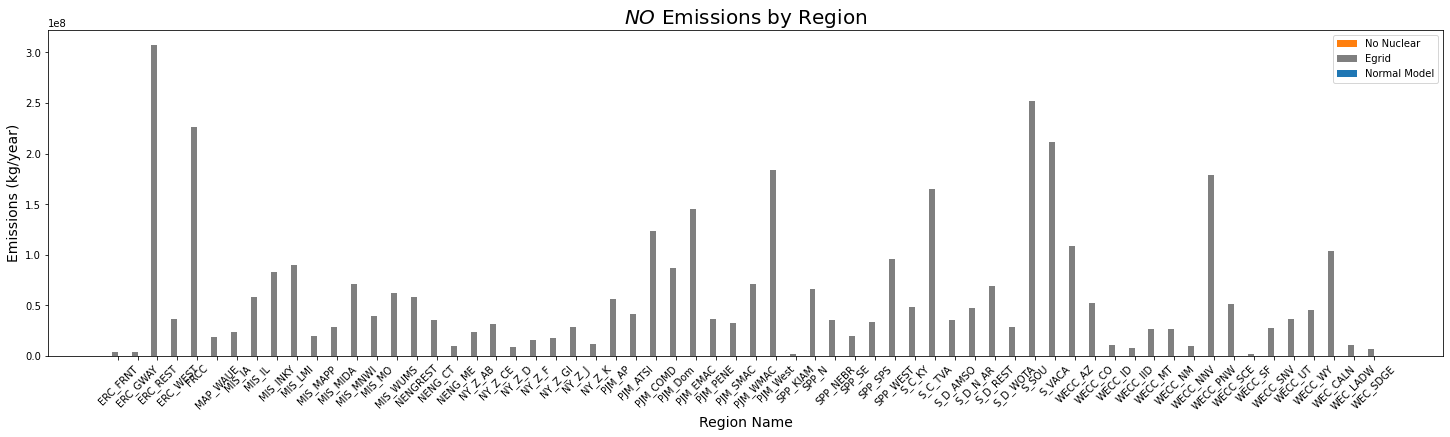

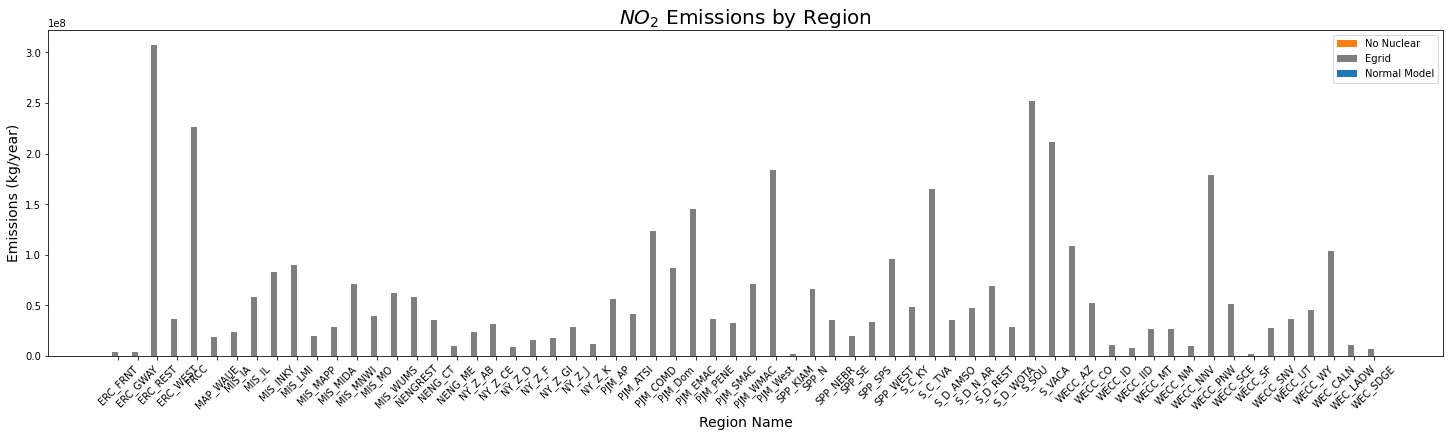

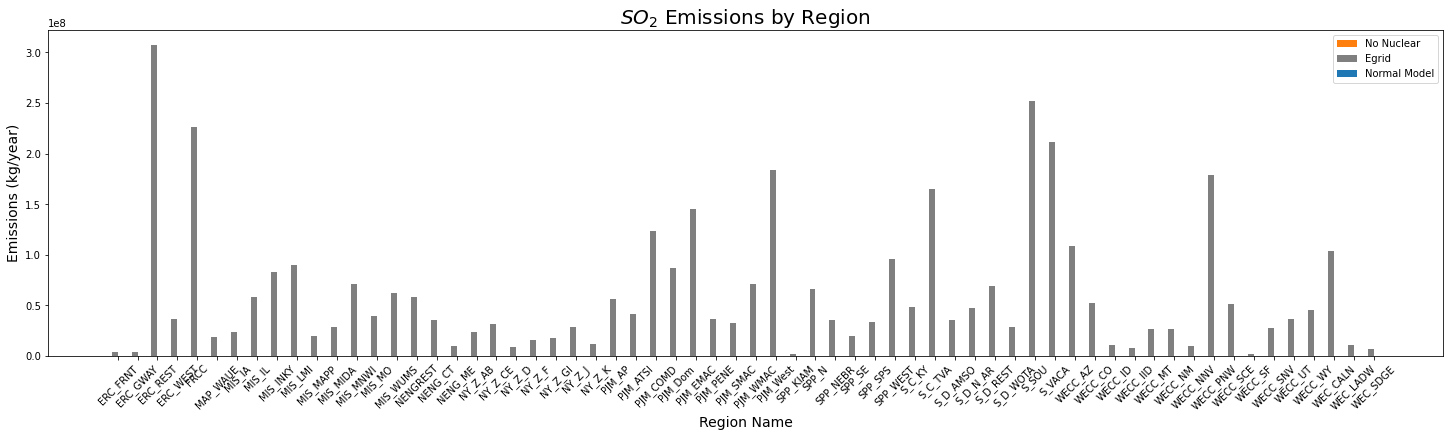

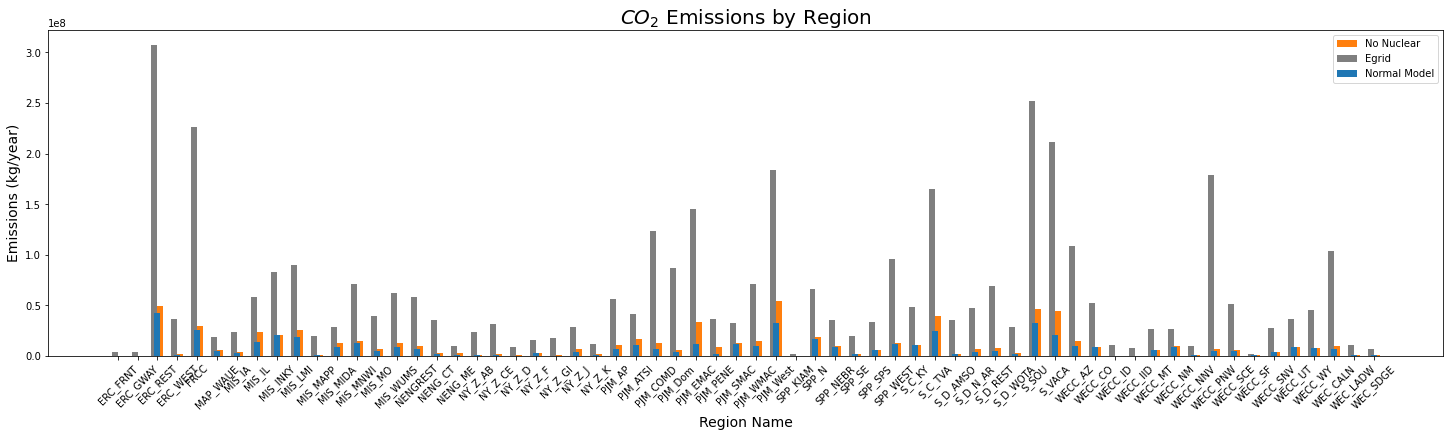

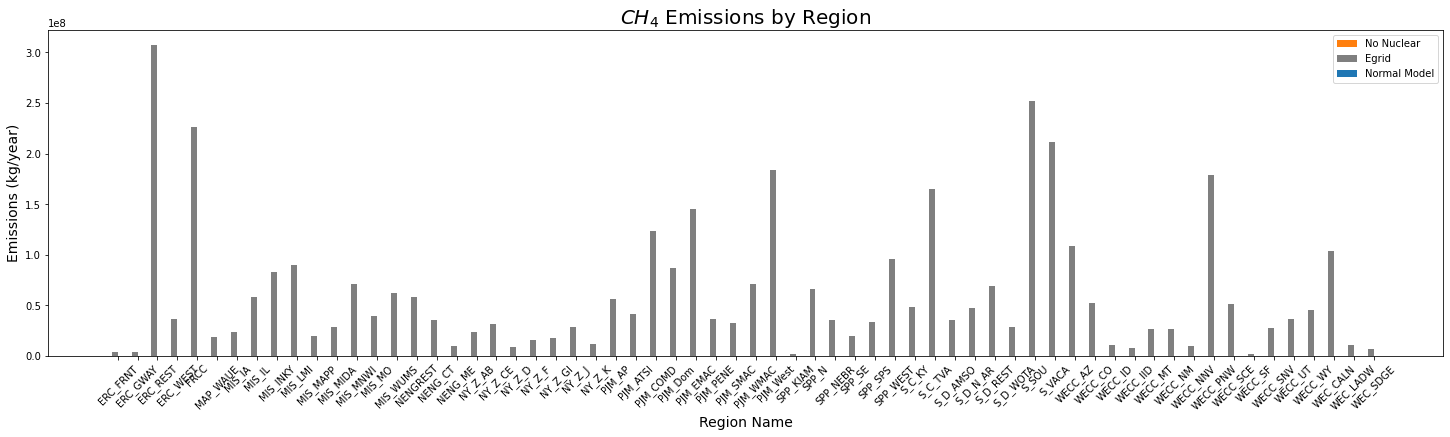

In [108]:
for pollutant in pollutants:
    #plot by region
    plotting.plant_region_plot(regionname_grouped_ds, xvariable = 'regionname',egrid = True, yvariable1 = f'annual_{pollutant}', egrid_yvariable = 'egridgeneration', figsize = [25,6])
    plt.xlabel('Region Name', fontsize = 14)
    plt.ylabel(f'Emissions (kg/year)', fontsize = 14)
    plt.title(f'{sci_names[pollutant]} Emissions by Region', fontsize = 20);


## Percent Change in Pollutants

In [50]:
### make a percent change variable in pollutants
for pollutant in pollutants:
    fueltype_grouped_ds.sel(model_name = 'nonuc')[f'{pollutant}_percent_change'] = 100* ((fueltype_grouped_ds.sel(model_name = 'nonuc')[f'annual_{pollutant}'] - 
                                 fueltype_grouped_ds.sel(model_name = 'normal')[f'annual_{pollutant}'])/fueltype_grouped_ds.sel(model_name = 'normal')[f'annual_{pollutant}'])

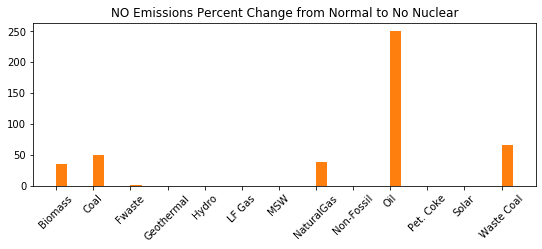

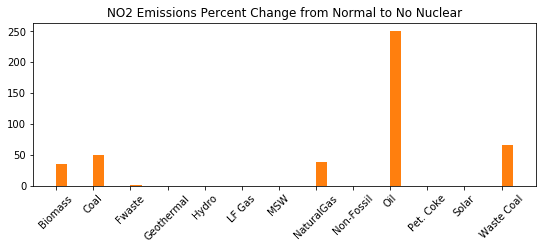

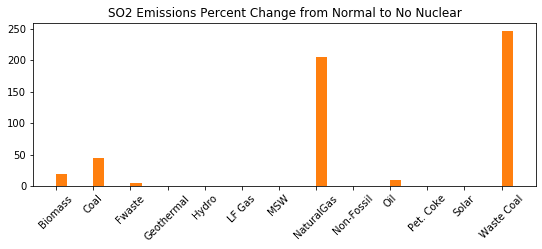

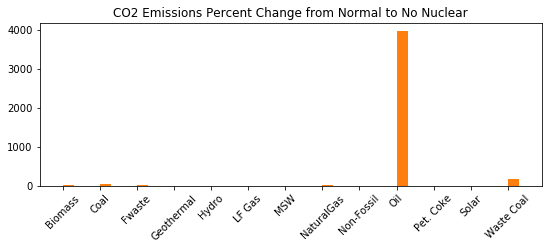

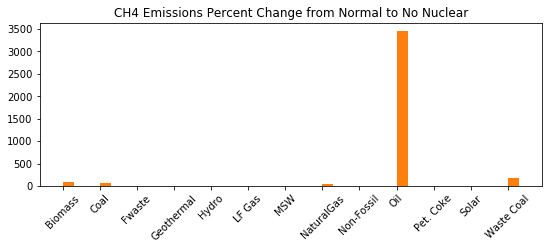

In [51]:
for pollutant in pollutants:
    plotting.plant_region_plot(ds = fueltype_grouped_ds, xvariable = 'fueltype', yvariable1 = f'{pollutant}_percent_change',
                      egrid = False, yvariable2 = 'fueltype', figsize = [9,3], normal = False)
    plt.legend().remove()
    plt.title(f'{pollutant} Emissions Percent Change from Normal to No Nuclear')

In [53]:
for pollutant in pollutants:
    print(f'Coal {pollutant} increase ' +
          str(fueltype_grouped_ds.sel(model_name = 'nonuc')[f'{pollutant}_percent_change'].sel(fueltype = 'Coal').values))
    print(f'Natural Gas {pollutant} increase ' +
          str(fueltype_grouped_ds.sel(model_name = 'nonuc')[f'{pollutant}_percent_change'].sel(fueltype = 'NaturalGas').values))

Coal NO increase 49.65318080562237
Natural Gas NO increase 39.59710998639442
Coal NO2 increase 49.653180805622284
Natural Gas NO2 increase 39.59710998639446
Coal SO2 increase 44.69144642218754
Natural Gas SO2 increase 205.5076302229292
Coal CO2 increase 47.918794298511344
Natural Gas CO2 increase 24.94924122542257
Coal CH4 increase 68.20107905730161
Natural Gas CH4 increase 55.00814301541011


## Ratio of Emissions Change to Generation Changes

In [36]:
for pollutant in pollutants:
    plant_region_plot(fueltype_grouped_ds, xvariable = 'fueltype',egrid = False, yvariable1 = f'normal-nonuc_{pollutant}-gen_ratio', yvariable2 = 'egridgeneration', figsize = [16,6], normal = False)
    plt.xlabel('Region Name', fontsize = 14)
    plt.ylabel(f'{pollutant} Emissions/Generation Ratio', fontsize = 14)
    plt.legend().remove()
    plt.title(f'Normal and No Nuclear {pollutant} Difference in Emissions to Generation Ratio by Fuel Type', fontsize = 16);

for pollutant in pollutants:
    plant_region_plot(regionname_grouped_ds, xvariable = 'regionname',egrid = False, yvariable1 = f'normal-nonuc_{pollutant}-gen_ratio', yvariable2 = 'egridgeneration', figsize = [25,6], normal = False)
    plt.xlabel('Region Name', fontsize = 14)
    plt.ylabel(f'{pollutant} Emissions/Generation Ratio', fontsize = 14)
    plt.legend().remove()
    plt.title(f'Normal and No Nuclear {pollutant} Difference in Emissions to Generation Ratio by Region Name', fontsize = 16);

NameError: name 'plant_region_plot' is not defined